In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20

Dataset URL: https://www.kaggle.com/datasets/joydippaul/mpox-skin-lesion-dataset-version-20-msld-v20
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 97% 548M/567M [00:07<00:00, 86.1MB/s]
100% 567M/567M [00:07<00:00, 76.7MB/s]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/mpox-skin-lesion-dataset-version-20-msld-v20.zip','r')
zip_ref.extractall ('/content')
zip_ref.close()

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/HAM10000.zip','r')
dataset_dir= zip_ref.extractall ('/content')
zip_ref.close()

In [6]:
#Importing all the required libraries
!pip install innvestigate
import innvestigate
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import pandas as pd
#for Math operations
import numpy as np
#Machine learning libraries
import os
from random import shuffle
from shutil import copyfile
import random
#for opening and loading images
!pip install opencv-python
import cv2
# for Preprocessing
from tensorflow.keras.preprocessing import image
#for visualization
import plotly.express as px
import matplotlib.pyplot as plt
#convert class labels to one-hot encoded vectors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from keras.optimizers import Adam

from numpy import loadtxt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: te

In [7]:
train_folder = "/content/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train"
val_folder = "/content/Original Images/Original Images/FOLDS/fold5/Valid"
test_folder = "/content/Original Images/Original Images/FOLDS/fold5/Test"

In [8]:
BATCH_SIZE = 16
train_gen = ImageDataGenerator(rescale=1./255)  # Normalization done to rescale the pixel values of the images to a range of [0, 1] by dividing by 255
train_data = train_gen.flow_from_directory(directory=train_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

val_gen = ImageDataGenerator(rescale=1./255)
val_data = val_gen.flow_from_directory(directory=val_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)

test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(directory=test_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False, seed = 42)
train_data.class_indices

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


{'Chickenpox': 0,
 'Cowpox': 1,
 'HFMD': 2,
 'Healthy': 3,
 'Measles': 4,
 'Monkeypox': 5}

In [9]:
x,y = next(train_data)
x.shape

(16, 224, 224, 3)

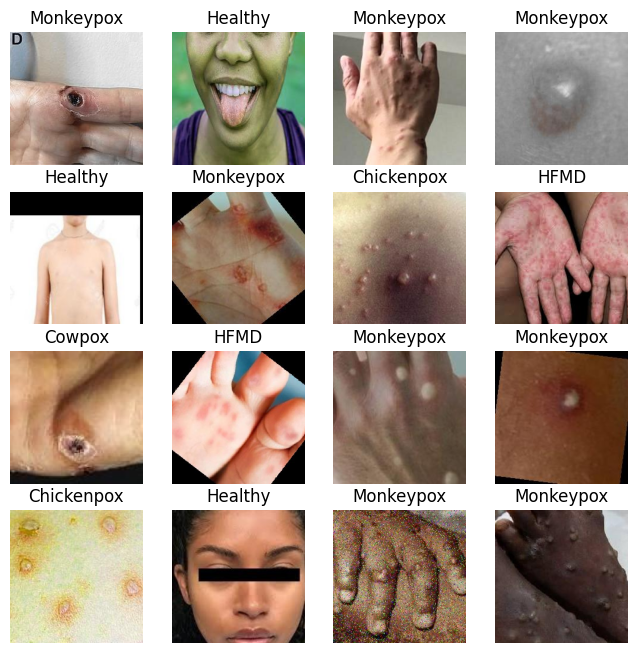

In [10]:

a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[8, 10])
    for i in range(len(img)):
        plt.subplot(5, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(x,y)

In [11]:
# def class_distrubution(folder):
#   # Calculate class distribution
#   class_names = os.listdir(folder)
#   class_dis = [len(os.listdir(folder + "/" + name)) for name in class_names]
#   fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
#   fig.update_layout(title_x = 0.47)
#   fig.show()



In [12]:
# class_distrubution(train_folder)
# #class_distrubution(val_folder)

Data Augmentation

In [13]:
# Data augmentation
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,                       # Normalization done to rescale the pixel values of the images to a range of [0, 1] by dividing by 255
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_directory(directory=train_folder, target_size=(224,224),batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=42)


Found 7532 images belonging to 6 classes.


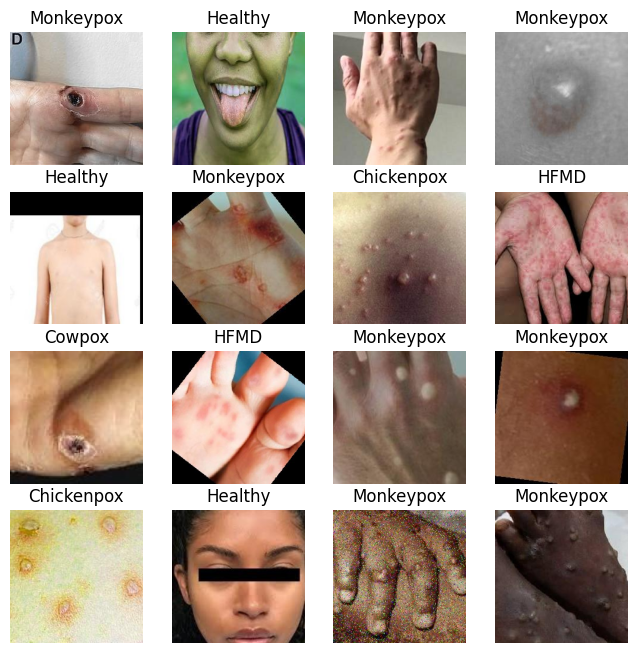

In [14]:
# Display sample data after augmentation
a = train_data.class_indices
class_names = list(a.keys())  # storing class/breed names in a list


def plot_images(img, labels):
    plt.figure(figsize=[8, 10])
    for i in range(len(img)):
        plt.subplot(5, 4, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()
plot_images(x,y)

Load HAM10000 dataset


In [15]:

# Define paths to HAM10000 dataset
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/HAM1000'
ham_part1 = os.path.join(dataset_dir, '/content/ham10000_images_part_1')
ham_part2 = os.path.join(dataset_dir, '/content/ham10000_images_part_2')
metadata_path = os.path.join(dataset_dir, '/content/HAM10000_metadata.csv')
output_dir = '/content/drive/MyDrive/Colab Notebooks/HAM10000'

# Load metadata
metadata = pd.read_csv(metadata_path)

class_mapping = {
    'akiec': 'class1',
    'bcc': 'class2',
    'bkl': 'class3',
    'df': 'class4',
    'mel': 'class5',
    'nv': 'class6',
    'vasc': 'class7'
}


In [16]:
# Create directories
for split in ['train', 'validation', 'test']:
    for class_name in class_mapping.values():
        os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# Split metadata into training, validation, and test sets
train_val_df, test_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['dx'], random_state=42)

# Helper function to copy images to corresponding directories
def copy_images(df, split):
    for _, row in df.iterrows():
        img_name = row['image_id'] + '.jpg'
        if os.path.exists(os.path.join(ham_part1, img_name)):
            src_path = os.path.join(ham_part1, img_name)
        else:
            src_path = os.path.join(ham_part2, img_name)
        dst_dir = os.path.join(output_dir, split, class_mapping[row['dx']])
        copyfile(src_path, os.path.join(dst_dir, img_name))

# Copy images to respective directories
copy_images(train_df, 'train')
copy_images(val_df, 'validation')
copy_images(test_df, 'test')

print("Dataset organized successfully.")

Dataset organized successfully.


In [17]:
# Define paths
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/HAM10000'

# Define ImageDataGenerators
ham_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

ham_val_datagen = ImageDataGenerator(rescale=1./255)

ham_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
ham_train_generator = ham_train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

ham_val_generator = ham_val_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'validation'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

ham_test_generator = ham_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6009 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


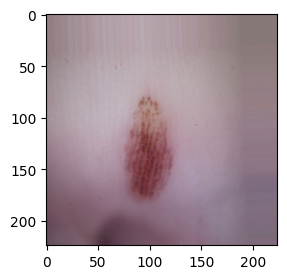

In [18]:
plt.figure(figsize=(3,3))
plt.imshow(ham_train_generator[0][0][0])

In [19]:
# Combine the datasets
# # Define paths
# ham10000_dir = '/content/drive/MyDrive/Colab Notebooks/HAM10000'
# monkeypox_dir = '/content/mpox-skin-lesion-dataset-version-20-msld-v20'

# # Define ImageDataGenerators
# datagen = ImageDataGenerator(rescale=1./255)

# def create_generator(base_dir, target_size=(224, 224), batch_size=32):
#     train_gen = datagen.flow_from_directory(
#         directory=os.path.join(base_dir, 'train'),
#         target_size=target_size,
#         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=True
#     )
#     val_gen = datagen.flow_from_directory(
#         directory=os.path.join(base_dir, 'validation'),
#         target_size=target_size,
#         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=False
#     )
#     test_gen = datagen.flow_from_directory(
#         directory=os.path.join(base_dir, 'test'),
#         target_size=target_size,
#         batch_size=batch_size,
#         class_mode='categorical',
#         shuffle=False
#     )
#     return train_gen, val_gen, test_gen

# # Create generators for both datasets
# ham_train_gen, ham_val_gen, ham_test_gen = create_generator(ham10000_dir)
# monkeypox_train_gen, monkeypox_val_gen, monkeypox_test_gen = create_generator(monkeypox_dir)

# # Combine generators
# def combined_generator(gen1, gen2):
#     while True:
#         X1, y1 = gen1.next()
#         X2, y2 = gen2.next()
#         yield np.concatenate([X1, X2]), np.concatenate([y1, y2])

# combined_train_gen = combined_generator(ham_train_gen, monkeypox_train_gen)
# combined_val_gen = combined_generator(ham_val_gen, monkeypox_val_gen)
# combined_test_gen = combined_generator(ham_test_gen, monkeypox_test_gen)

# # Determine steps per epoch
# steps_per_epoch_train = min(len(ham_train_gen), len(monkeypox_train_gen))
# steps_per_epoch_val = min(len(ham_val_gen), len(monkeypox_val_gen))
# steps_per_epoch_test = min(len(ham_test_gen), len(monkeypox_test_gen))


# Building the Model

## Model 1 : ResNet50

In [20]:
# # Create TensorFlow datasets from ImageDataGenerators(to be continused from above where we created train_data, val_data, test_data from flow_from_directory command)
# train_dataset = tf.data.Dataset.from_generator(lambda: train_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, train_data.num_classes]))
# val_dataset = tf.data.Dataset.from_generator(lambda: val_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, val_data.num_classes]))
# test_dataset = tf.data.Dataset.from_generator(lambda: test_data, output_types=(tf.float32, tf.float32), output_shapes=([None, 224, 224, 3], [None, test_data.num_classes]))

# # Apply prefetch and autotune
# train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# Callbacks are used to perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).
# In our case, we are using Modelcheckpoint for saving the model weights into the disk for a minimum value of validation loss. Further,
# we are also using ReduceLROnPlateau for reducing the learning rate of the model by a factor of 0.5 if its validation loss doesn’t improve for 3 consecutive epochs.

checkpoint = ModelCheckpoint('.mdl1_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]


In [22]:
# Load the ResNet50 model pretrained on ImageNet data and use fine tuning

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


Pre-train on HAM10000 dataset

In [23]:
# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

# Add custom layers for HAM10000
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes_ham, activation='softmax')(x)

model_ham = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

Epoch 1/10
188/188 [==============================] - 230s 1s/step - loss: 1.1837 - accuracy: 0.6525 - val_loss: 1.1382 - val_accuracy: 0.6695
Epoch 2/10
188/188 [==============================] - 224s 1s/step - loss: 1.1330 - accuracy: 0.6695 - val_loss: 1.1294 - val_accuracy: 0.6695
Epoch 3/10
188/188 [==============================] - 224s 1s/step - loss: 1.1280 - accuracy: 0.6693 - val_loss: 1.1157 - val_accuracy: 0.6695
Epoch 4/10
188/188 [==============================] - 218s 1s/step - loss: 1.1227 - accuracy: 0.6690 - val_loss: 1.1169 - val_accuracy: 0.6695
Epoch 5/10
188/188 [==============================] - 218s 1s/step - loss: 1.1178 - accuracy: 0.6692 - val_loss: 1.1033 - val_accuracy: 0.6695
Epoch 6/10
188/188 [==============================] - 218s 1s/step - loss: 1.1118 - accuracy: 0.6695 - val_loss: 1.1005 - val_accuracy: 0.6695
Epoch 7/10
188/188 [==============================] - 219s 1s/step - loss: 1.1123 - accuracy: 0.6695 - val_loss: 1.1028 - val_accuracy: 0.6705

Modify the Model for Monkeypox

In [24]:

# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

Fine-tune on Monkepypox dataset

In [25]:
# Unfreeze all layers for fine-tuning
for layer in conv_base.layers[:]:
    layer.trainable = True

# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics = ["accuracy"])

#
history = model_mpox.fit(
    train_data,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=40,verbose=1, callbacks=callbacks
)

Epoch 1/40
471/471 [==============================] - ETA: 0s - loss: 1.6602 - accuracy: 0.2416
Epoch 1: val_accuracy improved from -inf to 0.12338, saving model to .mdl1_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


471/471 [==============================] - 520s 1s/step - loss: 1.6602 - accuracy: 0.2416 - val_loss: 1.7987 - val_accuracy: 0.1234 - lr: 1.0000e-05
Epoch 2/40
471/471 [==============================] - ETA: 0s - loss: 1.5507 - accuracy: 0.3409
Epoch 2: val_accuracy improved from 0.12338 to 0.40260, saving model to .mdl1_wts.hdf5
471/471 [==============================] - 501s 1s/step - loss: 1.5507 - accuracy: 0.3409 - val_loss: 1.5640 - val_accuracy: 0.4026 - lr: 1.0000e-05
Epoch 3/40
471/471 [==============================] - ETA: 0s - loss: 1.5167 - accuracy: 0.3678
Epoch 3: val_accuracy improved from 0.40260 to 0.41558, saving model to .mdl1_wts.hdf5
471/471 [==============================] - 500s 1s/step - loss: 1.5167 - accuracy: 0.3678 - val_loss: 1.5338 - val_accuracy: 0.4156 - lr: 1.0000e-05
Epoch 4/40
471/471 [==============================] - ETA: 0s - loss: 1.4950 - accuracy: 0.3898
Epoch 4: val_accuracy did not improve from 0.41558
471/471 [==============================]

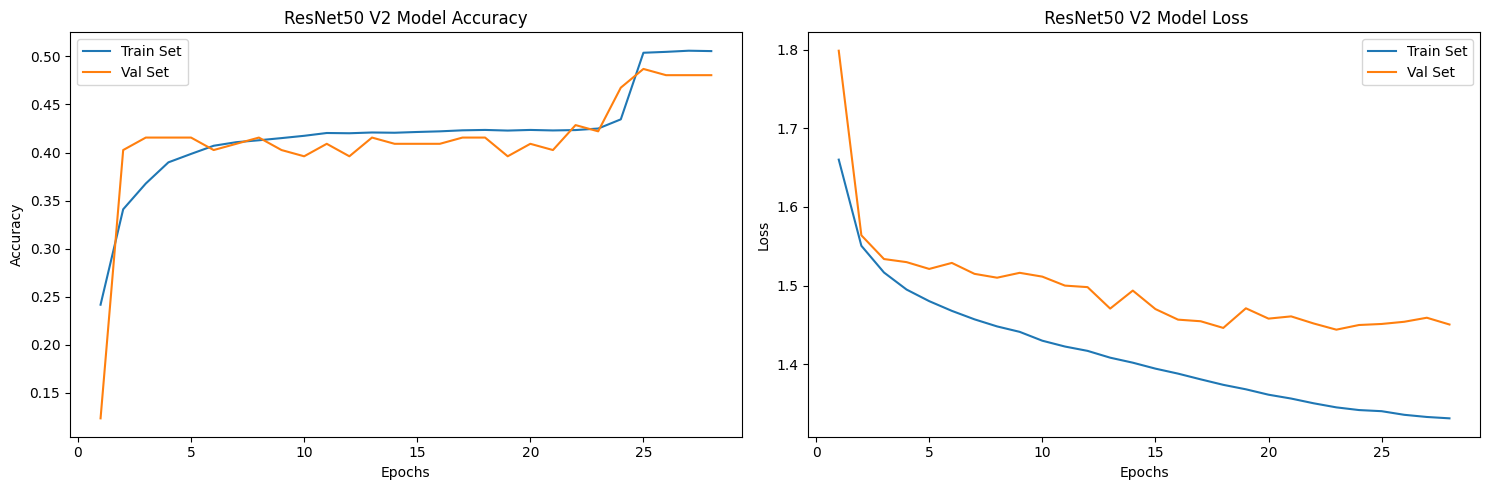

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' ResNet50 V2 Model Loss')

plt.tight_layout()
plt.show()

In [27]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl1_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 4s 267ms/step - loss: 1.4513 - accuracy: 0.4870
[1.4512684345245361, 0.48701298236846924]


model performed moderately well on test data with an overall validation accuracy of ---%. But now we will evaluate it on completely unseen test data so that we can assess its performance in a real sense

In [28]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 270ms/step - loss: 1.3935 - accuracy: 0.4921

 Test_Accuracy:- 0.4920634925365448


Confusion Matrix

4/4 [==============================] - 2s 265ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       1.00      0.29      0.44         7
           2       0.37      1.00      0.54        15
           3       0.91      1.00      0.95        10
           4       0.50      0.67      0.57         6
           5       0.00      0.00      0.00        18

    accuracy                           0.49        63
   macro avg       0.46      0.49      0.42        63
weighted avg       0.39      0.49      0.38        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


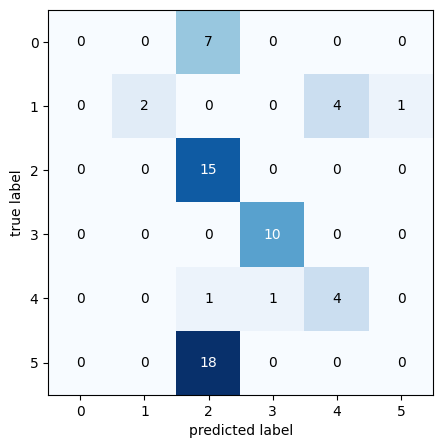

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("ResNet50-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

ResNet50-based Model Accuracy: 49.21%
Precision: 0.462
Recall: 0.492
F1 Score: 0.417


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model 2: MobileNet V2



In [31]:
checkpoint = ModelCheckpoint('.mdl2_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [32]:
conv_base = MobileNetV2(
    include_top=False,
    weights='imagenet')

# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(num_classes_ham, activation='softmax')(x)
model_ham = Model(conv_base.input, predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
188/188 [==============================] - 151s 789ms/step - loss: 2.7271 - accuracy: 0.1774 - val_loss: 1.7241 - val_accuracy: 0.3824
Epoch 2/10
188/188 [==============================] - 146s 776ms/step - loss: 2.3945 - accuracy: 0.2353 - val_loss: 1.4784 - val_accuracy: 0.5182
Epoch 3/10
188/188 [==============================] - 147s 783ms/step - loss: 2.1677 - accuracy: 0.3037 - val_loss: 1.3017 - val_accuracy: 0.6051
Epoch 4/10
188/188 [==============================] - 149s 793ms/step - loss: 1.9785 - accuracy: 0.3625 - val_loss: 1.2413 - val_accuracy: 0.6236
Epoch 5/10
188/188 [==============================] - 149s 795ms/step - loss: 1.7971 - accuracy: 0.4132 - val_loss: 1.2304 - val_accuracy: 0.6181
Epoch 6/10
188/188 [==============================] - 149s 793ms/step - loss: 1.7344 - accuracy: 0.4523 - val_loss: 1.1600 - val_accuracy: 0.6425
Epoch 7/10
188/188 [==============================] - 149s 79

In [33]:
# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

In [34]:
# Unfreeze some layers in the base model

for layer in conv_base.layers[:100]:  # Freeze first 150 layers
    layer.trainable = False
for layer in conv_base.layers[100:]:  # Unfreeze the rest
    layer.trainable = True
# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics = ["accuracy"])


history = model_mpox.fit(
    train_data,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=40,verbose=1, callbacks=callbacks
)

Epoch 1/40
471/471 [==============================] - ETA: 0s - loss: 1.7427 - accuracy: 0.3105
Epoch 1: val_accuracy improved from -inf to 0.35714, saving model to .mdl2_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


471/471 [==============================] - 125s 250ms/step - loss: 1.7427 - accuracy: 0.3105 - val_loss: 1.7306 - val_accuracy: 0.3571 - lr: 1.0000e-05
Epoch 2/40
471/471 [==============================] - ETA: 0s - loss: 1.6988 - accuracy: 0.3526
Epoch 2: val_accuracy did not improve from 0.35714
471/471 [==============================] - 117s 249ms/step - loss: 1.6988 - accuracy: 0.3526 - val_loss: 1.6749 - val_accuracy: 0.3571 - lr: 1.0000e-05
Epoch 3/40
471/471 [==============================] - ETA: 0s - loss: 1.6643 - accuracy: 0.3862
Epoch 3: val_accuracy improved from 0.35714 to 0.38961, saving model to .mdl2_wts.hdf5
471/471 [==============================] - 117s 248ms/step - loss: 1.6643 - accuracy: 0.3862 - val_loss: 1.6249 - val_accuracy: 0.3896 - lr: 1.0000e-05
Epoch 4/40
471/471 [==============================] - ETA: 0s - loss: 1.6374 - accuracy: 0.4254
Epoch 4: val_accuracy improved from 0.38961 to 0.46104, saving model to .mdl2_wts.hdf5
471/471 [======================

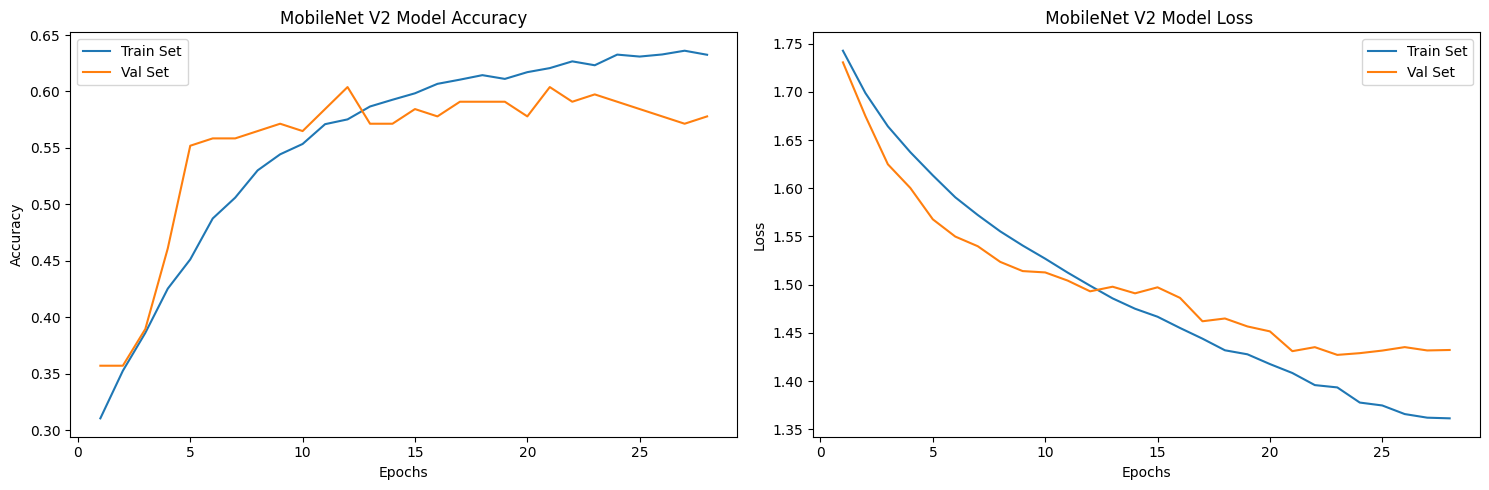

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet V2 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' MobileNet V2 Model Loss')

plt.tight_layout()
plt.show()

In [36]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl2_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 2s 75ms/step - loss: 1.4931 - accuracy: 0.6039
[1.493088960647583, 0.6038960814476013]


In [37]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 0s 79ms/step - loss: 1.4982 - accuracy: 0.5556

 Test_Accuracy:- 0.5555555820465088


4/4 [==============================] - 1s 72ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.80      0.57      0.67         7
           2       0.52      1.00      0.68        15
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         6
           5       0.57      0.89      0.70        18

    accuracy                           0.56        63
   macro avg       0.31      0.41      0.34        63
weighted avg       0.38      0.56      0.44        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


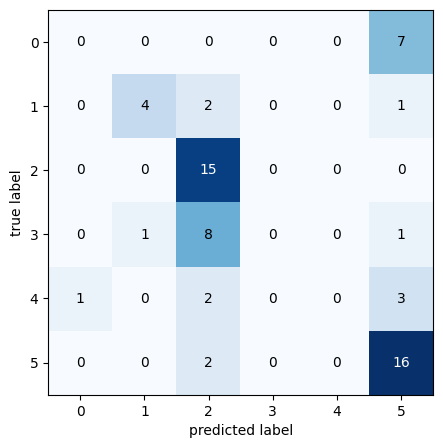

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("MobileNet-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


MobileNet-based Model Accuracy: 55.56%
Precision: 0.315
Recall: 0.410
F1 Score: 0.341


### Model 3 : DenseNet121


In [40]:
checkpoint = ModelCheckpoint('.mdl3_wts.hdf5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2,
                                   verbose=1, mode='min', min_lr=0.0000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
callbacks = [checkpoint,reduce_lr, early_stopping]

In [41]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet data
conv_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Number of classes in HAM10000
num_classes_ham = 7

# Freeze base model layers
for layer in conv_base.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes_ham, activation='softmax')(x)
model_ham = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
model_ham.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ["accuracy"])

# Train the model
history = model_ham.fit(
    ham_train_generator, batch_size=BATCH_SIZE,
    validation_data=ham_val_generator, verbose=1,
    epochs=10
)

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/10
188/188 [==============================] - 215s 1s/step - loss: 1.0127 - accuracy: 0.6667 - val_loss: 0.8631 - val_accuracy: 0.6895
Epoch 2/10
188/188 [==============================] - 206s 1s/step - loss: 0.8159 - accuracy: 0.7091 - val_loss: 0.7968 - val_accuracy: 0.7019
Epoch 3/10
188/188 [==============================] - 206s 1s/step - loss: 0.7652 - accuracy: 0.7208 - val_loss: 0.7881 - val_accuracy: 0.7089
Epoch 4/10
188/188 [==============================] - 207s 1s/step - loss: 0.7411 - accuracy: 0.7296 - val_loss: 0.7578 - val_accuracy: 0.7254
Epoch 5/10
188/188 [==============================] - 207s 1s/step - loss: 0.7123 - accuracy: 0.7421 - val_loss: 0.7398 - val_accuracy: 0.7244
Epoch 6/10
188/188 [==============================] - 207s 1s/step - loss: 0.6989 - accuracy: 0.7504 - val_loss: 0.7467 - val_accuracy: 0.7239
Epoch 7/10
188/188 [==============================] - 206s 1s/step - loss: 0.

In [42]:
# Number of classes in the Monkeypox dataset
num_classes_mpox = 6

# Remove the last layer (HAM10000 classifier)
model_ham.layers.pop()

# Add a new dense layer for the Monkeypox dataset
x = model_ham.layers[-1].output
predictions = Dense(num_classes_mpox, activation='softmax')(x)

model_mpox = Model(inputs=model_ham.input, outputs=predictions)

In [43]:
# Unfreeze some layers in the base model

for layer in conv_base.layers[:150]:  # Freeze first 150 layers
    layer.trainable = False
for layer in conv_base.layers[150:]:  # Unfreeze the rest
    layer.trainable = True
# Re-compile model with a lower learning rate
model_mpox.compile(optimizer = Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics = ["accuracy"])


history = model_mpox.fit(
    train_data,
    validation_data=val_data,
    batch_size = BATCH_SIZE,
    epochs=40,verbose=1, callbacks=callbacks
)

Epoch 1/40
471/471 [==============================] - ETA: 0s - loss: 1.6747 - accuracy: 0.0854
Epoch 1: val_accuracy improved from -inf to 0.13636, saving model to .mdl3_wts.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


471/471 [==============================] - 299s 589ms/step - loss: 1.6747 - accuracy: 0.0854 - val_loss: 1.6533 - val_accuracy: 0.1364 - lr: 1.0000e-05
Epoch 2/40
471/471 [==============================] - ETA: 0s - loss: 1.5929 - accuracy: 0.3225
Epoch 2: val_accuracy improved from 0.13636 to 0.28571, saving model to .mdl3_wts.hdf5
471/471 [==============================] - 276s 585ms/step - loss: 1.5929 - accuracy: 0.3225 - val_loss: 1.6158 - val_accuracy: 0.2857 - lr: 1.0000e-05
Epoch 3/40
471/471 [==============================] - ETA: 0s - loss: 1.5534 - accuracy: 0.4003
Epoch 3: val_accuracy improved from 0.28571 to 0.30519, saving model to .mdl3_wts.hdf5
471/471 [==============================] - 277s 587ms/step - loss: 1.5534 - accuracy: 0.4003 - val_loss: 1.6109 - val_accuracy: 0.3052 - lr: 1.0000e-05
Epoch 4/40
471/471 [==============================] - ETA: 0s - loss: 1.5310 - accuracy: 0.4246
Epoch 4: val_accuracy improved from 0.30519 to 0.34416, saving model to .mdl3_wts.

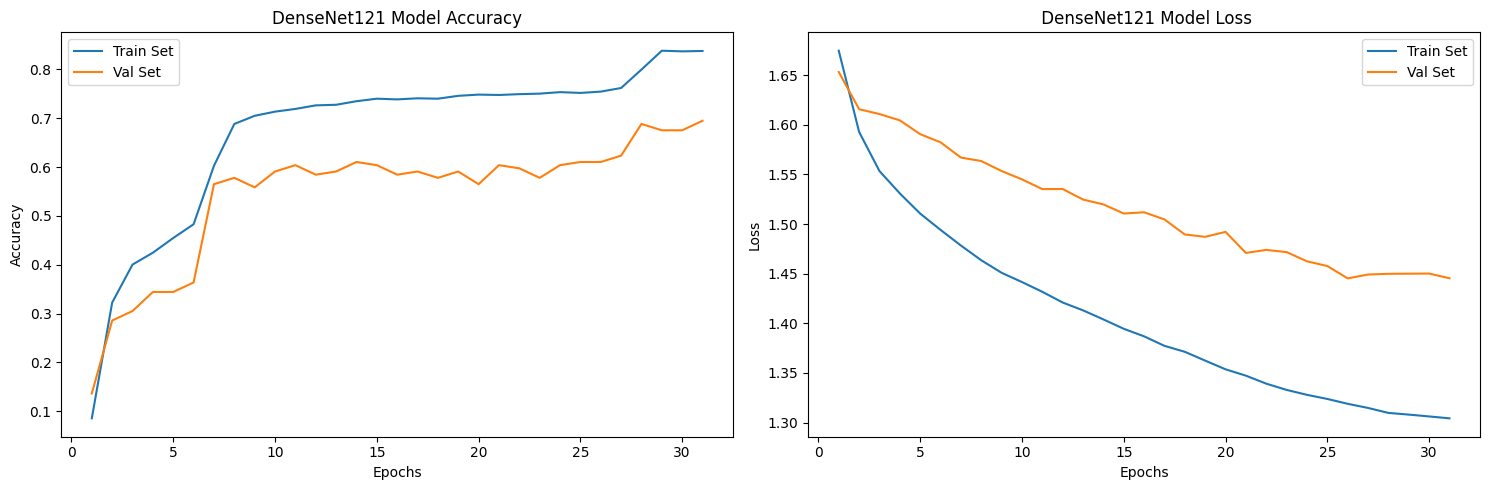

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(' DenseNet121 Model Loss')

plt.tight_layout()
plt.show()

In [45]:
#  we will load the best weights of the model with minimum validation loss and maximum validation accuracy so that we can evaluate the performance of the model on various performance metrics.
from keras.models import load_model
model = load_model('.mdl3_wts.hdf5')
#checking the score of the model
score=model.evaluate(val_data)
print(score)

10/10 [==============================] - 5s 274ms/step - loss: 1.4454 - accuracy: 0.6948
[1.4454048871994019, 0.6948052048683167]


In [46]:
# checking the accuracy on test data
accuracy = model.evaluate(test_data, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

4/4 [==============================] - 1s 277ms/step - loss: 1.3984 - accuracy: 0.7143

 Test_Accuracy:- 0.7142857313156128


4/4 [==============================] - 3s 259ms/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.00      0.00      0.00         7
           2       0.87      0.87      0.87        15
           3       0.50      0.90      0.64        10
           4       0.50      0.17      0.25         6
           5       0.74      0.94      0.83        18

    accuracy                           0.71        63
   macro avg       0.60      0.60      0.57        63
weighted avg       0.66      0.71      0.66        63



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


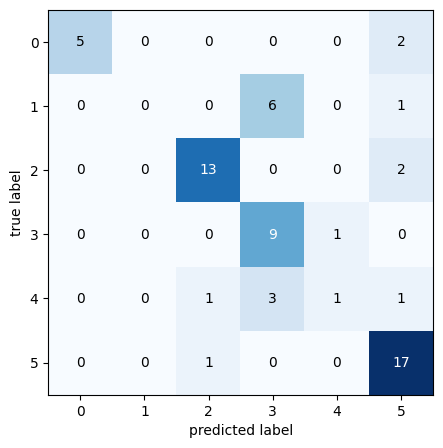

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Predict classes for the test data
y_pred = model.predict(test_data)

# Get the true labels from the test data generator
y_true = test_data.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

print('{}'.format(classification_report(y_true , y_pred_labels)))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat = conf_matrix, figsize = (5,5))
plt.show()

In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_classes = test_data.classes
acc = accuracy_score(true_classes, y_pred_labels)
print("DenseNet121-based Model Accuracy: {:.2f}%".format(acc * 100))

print('Precision: %.3f' % precision_score(true_classes, y_pred_labels,average='macro'))
print('Recall: %.3f' % recall_score(true_classes, y_pred_labels,average='macro'))
print('F1 Score: %.3f' % f1_score(true_classes, y_pred_labels,average='macro'))

DenseNet121-based Model Accuracy: 71.43%
Precision: 0.601
Recall: 0.599
F1 Score: 0.570


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Instructions for updating:
Colocations handled automatically by placer.


102967424/102967424 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/innvestigate/backend/graph.py:467: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")
/usr/local/lib/python3.10/dist-packages/innvestigate/backend/graph.py:480: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


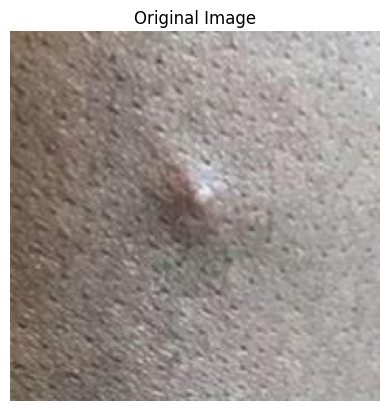

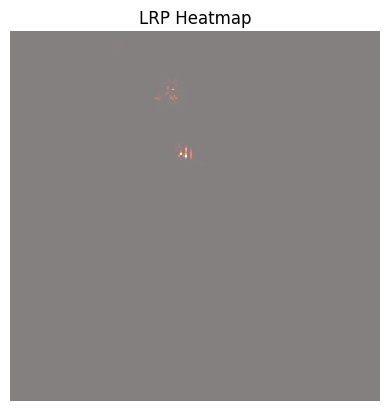

In [49]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = ResNet50(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_12_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("lrp.epsilon", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.5, interpolation='nearest')
plt.axis('off')
plt.title('LRP Heatmap')
plt.show()

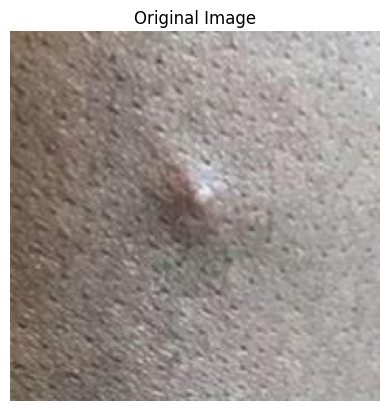

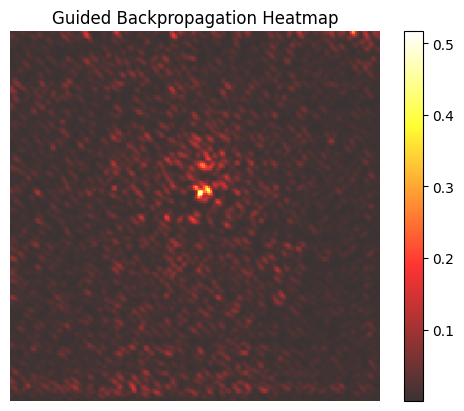

In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = ResNet50(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_12_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.8, interpolation='nearest')
plt.axis('off')
plt.title('Guided Backpropagation Heatmap')
plt.colorbar()
plt.show()


/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1505: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ret = tf_session.TF_SessionRunCallable(self._session._session,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


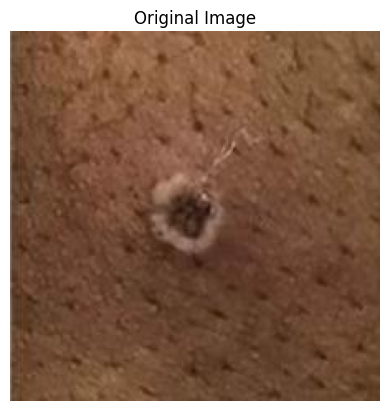

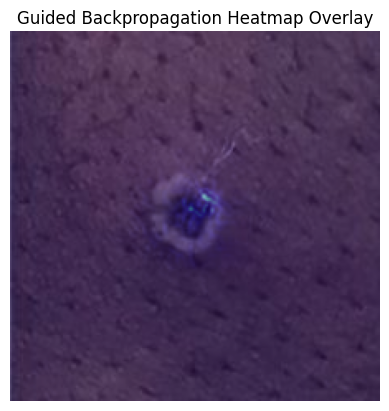

In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = MobileNetV2(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_14_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)  # Use Guided Backpropagation

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Overlay the relevance heatmap on the original image
img_original = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
heatmap = cv2.applyColorMap(np.uint8(255 * analysis), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

plt.imshow(overlay)
plt.axis('off')
plt.title('Guided Backpropagation Heatmap Overlay')
plt.show()


In [63]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image
import innvestigate
import cv2

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load pre-trained model
model = DenseNet121(weights='imagenet')

# Create a new model that excludes the softmax layer
model_without_softmax = tf.keras.Model(
    inputs=model.input,
    outputs=model.layers[-2].output  # Output of the layer before softmax
)

# Load an image
img_path = '/content/Original Images/Original Images/FOLDS/fold5/Test/Monkeypox/MKP_114_01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create an analyzer
analyzer = innvestigate.create_analyzer("guided_backprop", model_without_softmax)

# Analyze the image
analysis = analyzer.analyze(x)

# Postprocess the relevance map
analysis = analysis[0].sum(axis=2)  # Aggregate over the color channels
analysis = np.clip(analysis, 0, analysis.max())  # Clip negative values
analysis /= analysis.max()  # Normalize to [0, 1]
analysis = cv2.GaussianBlur(analysis, (5, 5), 0)  # Apply Gaussian blur for smoothing

# Display the original image
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()


# Display the relevance heatmap
plt.imshow(analysis, cmap="hot", alpha=0.8, interpolation='nearest')
plt.axis('off')
plt.title('Guided Backpropagation Heatmap')
plt.colorbar()
plt.show()


33188688/33188688 [==============================] - 0s 0us/step


KeyboardInterrupt: 